<a href="https://colab.research.google.com/github/ShiweiHe0713/Data-Science-for-Business-Techincal/blob/main/Model_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/CTVisMe/DS4B_Sp24.git
%cd DS4B_Sp24/ClassModules/Module5_ModelAssessment/

Cloning into 'DS4B_Sp24'...
remote: Enumerating objects: 807, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 807 (delta 96), reused 208 (delta 96), pack-reused 598
Receiving objects: 100% (807/807), 147.60 MiB | 15.09 MiB/s, done.
Resolving deltas: 100% (359/359), done.
Updating files: 100% (139/139), done.
/content/DS4B_Sp24/ClassModules/Module5_ModelAssessment/DS4B_Sp24/ClassModules/Module5_ModelAssessment


# Model Assessment


**Spring 2024 - Instructor:  Chris Volinsky**

**Teaching Assistants: Aditya Deshpande, Stuti Mishra, Krutika Savani**

**Original Notebooks courtesy of Prof. Foster Provost and Rubing Li**

***

Import all of the packages we will need.

In [ ]:
#


In [ ]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Our custom libraries!
import sys
sys.path.append("..")
from ds_utils.sample_data import *

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12

### Data
We're going to use a mail response data set from a real direct marketing campaign located in `data/mailing.csv`. Each record represents an individual who was targeted with a direct marketing offer.  The offer was a solicitation to make a charitable donation.

The columns (features) are:

```
income       household income
Firstdate    data assoc. with the first gift by this individual
Lastdate     data associated with the most recent gift
Amount       average amount by this individual over all periods (incl. zeros)
rfaf2        frequency code
rfaa2        donation amount code
pepstrfl     flag indicating a star donator
glast        amount of last gift
gavr         amount of average gift
```

The target variables is `class` and is equal to one if they gave in this campaign and zero otherwise.

In [ ]:
# Load the data
data = pd.read_csv("data/mailing.csv")
# Let's take a look at the data
data.head()

,Income,Firstdate,Lastdate,Amount,rfaf2,rfaa2,pepstrfl,glast,gavr,class
0,3,9409,9509,0.06,1,G,0,50,30.00,0
1,2,9201,9602,0.16,4,G,X,20,20.55,1
2,0,9510,9603,0.20,4,E,0,5,8.75,0
3,6,9409,9603,0.13,2,G,0,25,22.50,0
4,0,9310,9511,0.10,1,G,0,25,12.50,0


From the description above, and the head of the data, we see that two of the fields are **categorical** instead of typical **numerical** fields. Today, one of the models we will be using is a logistic regression. From the previous classes, we have seen that logistic regression requires *all* fields to be numerical. So, we are going to create "dummy" variables for all the fields that are categorical.

#### Dummyize
A dummy variable is a binary variable corresponding to one value of a categorical variable.
The typical way to create dummies for a field is to create new variables for each possible category of the field. For example consider a field called color that can have the possible values "red", "blue", and "green". To dummyize color, we would create three new features: "color_red", "color_blue", and "color_green". These fields would take the value 1 or 0 depending on the actual value of color. Each record can only have one of these fields set to 1.

Notes:

- You can also leave out one of the possible categories. For example, in the above example that had three possible values, you can create only two dummies. This, because when "color_red"=0 and "color_blue"=0 it means that "color_green=1".  

So.  Let's dummyize the fields `rfaa2` and `pepstrfl`.

In [ ]:
for field in ['rfaa2', 'pepstrfl']:
    dummies = pd.get_dummies(data[field])
    dummies.columns = [field + "_" + s for s in dummies.columns]
    data = pd.concat([data, dummies], axis=1).drop(field, axis="columns")

data.head()

,Income,Firstdate,Lastdate,Amount,rfaf2,glast,gavr,class,rfaa2_D,rfaa2_E,rfaa2_F,rfaa2_G,pepstrfl_0,pepstrfl_X
0,3,9409,9509,0.06,1,50,30.00,0,0,0,0,1,1,0
1,2,9201,9602,0.16,4,20,20.55,1,0,0,0,1,0,1
2,0,9510,9603,0.20,4,5,8.75,0,0,1,0,0,1,0
3,6,9409,9603,0.13,2,25,22.50,0,0,0,0,1,1,0
4,0,9310,9511,0.10,1,25,12.50,0,0,0,0,1,1,0


### Confusion matrices
Let's build a confusion matrix using a logistic regression model.

**Important and overlooked (always remember this!):** a confusion matrix is defined with respect to a classifier, not a scoring model.  However, our models *are* scoring models (e.g., class-probability estimation models).  So the confusion matrices are defined with respect a scoring model plus some decision logic -- when would you take one action versus another.  The most common decision logic is a *threshold* on the score.  The threshold should be chosen carefully, and with the business need in mind.   For binary classes, the default built in to most modeling *programs* when they return a predicted classification is to use a threshold corresponding to an estimated class probability of 0.5.  This is because the modeling program does not know the business setting, and 0.5 makes sense as a default (in expectation it gives the maximum classification accuracy, if the probabilities are well calibrated).  **However, 0.5 probably is not the right threshold for any particular problem.**

So let's start with the default of predicting a 1 if the estimated probability is $\geq$ 50% and a 0 otherwise.

Remember, a confusion matrix looks like:

```
  |____________ p __________|___________ n ___________|
Y |   True Positive         |   False Positive.       |
N |   False Negative.       |   True Negative.        |
```

In [ ]:
# Split our data into training and test sets
X = data.drop(['class'], axis=1)
Y = data['class']
X_mailing_train, X_mailing_test, Y_mailing_train, Y_mailing_test = train_test_split(X, Y, test_size=.25, random_state=42)

# Make and fit a model on the training data
model_mailing = LogisticRegression(C=1000000, solver='liblinear')
model_mailing.fit(X_mailing_train, Y_mailing_train)

# Get probabilities of being a donor (We saw this in a prior class)
probabilities = model_mailing.predict_proba(X_mailing_test)[:, 1]

Use the default threshold of 50% to decide Y vs N.

(An individual below this threshold will get a prediction of "0" and someone above this will get a prediction of "1")

In [ ]:
prediction = probabilities > 0.5

# Build and print a confusion matrix
confusion_matrix_50 = pd.DataFrame(metrics.confusion_matrix(Y_mailing_test, prediction, labels=[1, 0]).T,
                                columns=['p', 'n'], index=['Y', 'N'])
print (confusion_matrix_50)

      p      n
Y     0      1
N  2423  45521


Wait -- take a close look at that.  What's going on?

Incidentally, what would be the classification accuracy here?




What if we lower the threshold to 5%?

In [ ]:
# Let's move the threshold down
prediction = probabilities > 0.05

# Build and print a confusion matrix
confusion_matrix_5 = pd.DataFrame(metrics.confusion_matrix(Y_mailing_test, prediction, labels=[1, 0]).T,
                                columns=['p', 'n'], index=['Y', 'N'])
print (confusion_matrix_5)

      p      n
Y  1558  22281
N   865  23241


***
Is this good performance?

How can we tell?

Is 5% the right threshold?  How would we determine that?

## ROC Curves for comparing models

<img src="https://github.com/pearl-yu/foster_2022fall/blob/2022-master/Module5_ROC_Cost_Visualization/images/ROC1.png?raw=1" alt="Drawing" style="width: 600px;"/>

<img src="https://github.com/pearl-yu/foster_2022fall/blob/2022-master/Module5_ROC_Cost_Visualization/images/ROC2.png?raw=1" alt="Drawing" style="width: 600px;"/>


Doing this in **sklearn** is relatively straightforward.

Remember that the Area under the ROC curve (AUC) is a single value to compare models across all thresholds



###Comparing models with AUC  
We can now build and fit a model. Using several classification models, we will plot  *ROC curves* and overlay them to see which has the best performance.


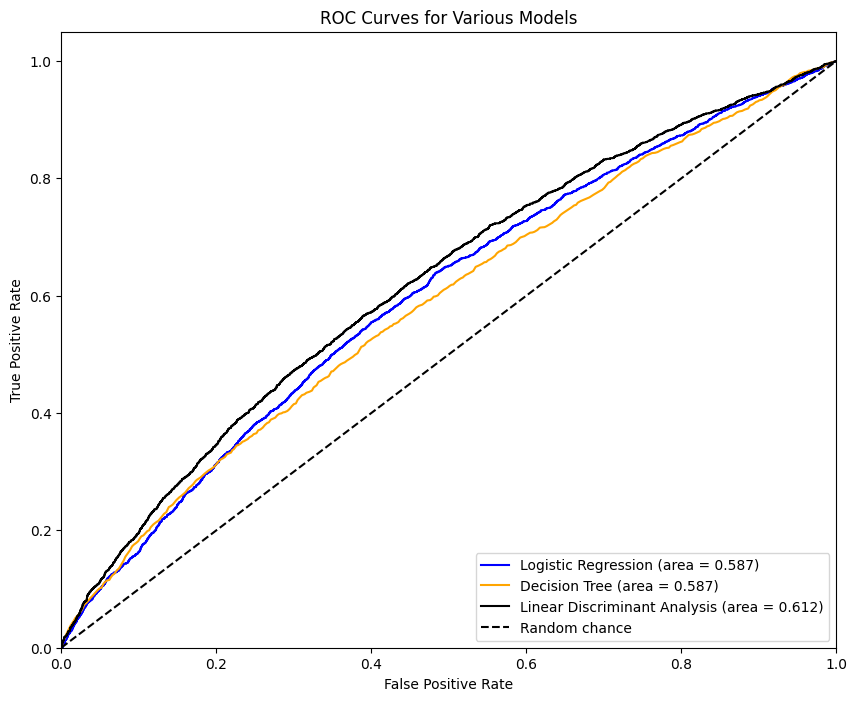

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm

X_train=X_mailing_train
X_test=X_mailing_test
Y_train=Y_mailing_train
Y_test=Y_mailing_test

# Fit models
# SVC takes a long time when prob = TRUE
models = {
    'Logistic Regression': LogisticRegression(C=1, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(criterion="entropy", min_samples_leaf=300, random_state=42),
 #   'SVM': SVC(probability=True, random_state=42,kernel='linear',C=0.1),  # Enable probability estimates
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
}

colors = {
    'Logistic Regression': 'blue',
    'Decision Tree': 'orange',
    'SVM': 'red',
    'Linear Discriminant Analysis': 'black',
}

# Dictionary to hold ROC data
roc_data = {}

for name, model in models.items():
    model.fit(X_mailing_train, Y_mailing_train)
    Y_pred_proba = model.predict_proba(X_mailing_test)[:,1]
    fpr, tpr, _ = roc_curve(Y_mailing_test, Y_pred_proba)
    #roc_auc = auc(fpr, tpr)
    roc_auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc", cv=5))
    roc_data[name] = (fpr, tpr, roc_auc)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.3f})',color=colors[name])

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc="lower right")
plt.show()


### Other measures: Cumulative response and lift curves
The interpretation of an ROC curve often is not intuitive to business stakeholders. In many applications the **cumulative response curve** is more useful.  It is very close to an ROC curve, except the x-axis is the percentage of all instances that are above each threshold.  


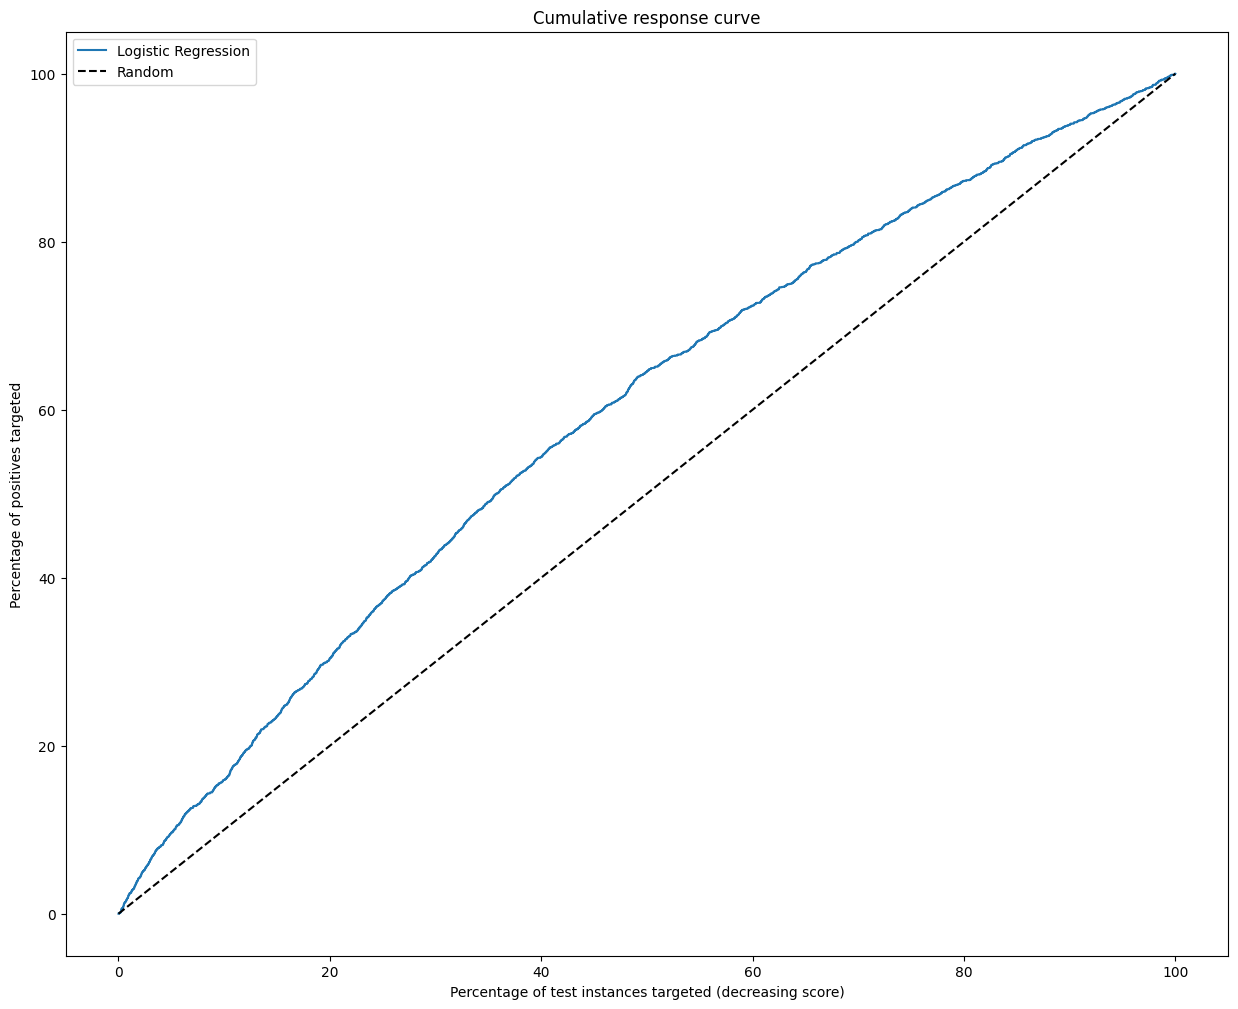

In [ ]:
def build_cumulative_curve(model, scale=100):
    # Fit model
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Sort theseprobabilities and the true value in descending order of probability
    order = np.argsort(Y_test_probability_1)[::-1]
    Y_test_probability_1_sorted = Y_test_probability_1[order]
    Y_test_sorted = np.array(Y_test)[order]

    # Build the cumulative response curve
    x_cumulative = np.arange(len(Y_test_probability_1_sorted)) + 1
    y_cumulative = np.cumsum(Y_test_sorted)

    # Rescale
    x_cumulative = np.array(x_cumulative)/float(x_cumulative.max()) * scale
    y_cumulative = np.array(y_cumulative)/float(y_cumulative.max()) * scale

    return x_cumulative, y_cumulative

def plot_cumulative_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [0,100], 'k--', label="Random")
    plt.xlabel("Percentage of test instances targeted (decreasing score)")
    plt.ylabel("Percentage of positives targeted")
    plt.title("Cumulative response curve")
    plt.legend()

models = {"Logistic Regression": LogisticRegression(C=1.0, solver="liblinear")}
plot_cumulative_curve(models)

We can also  plot a **lift curve** in this scenario.

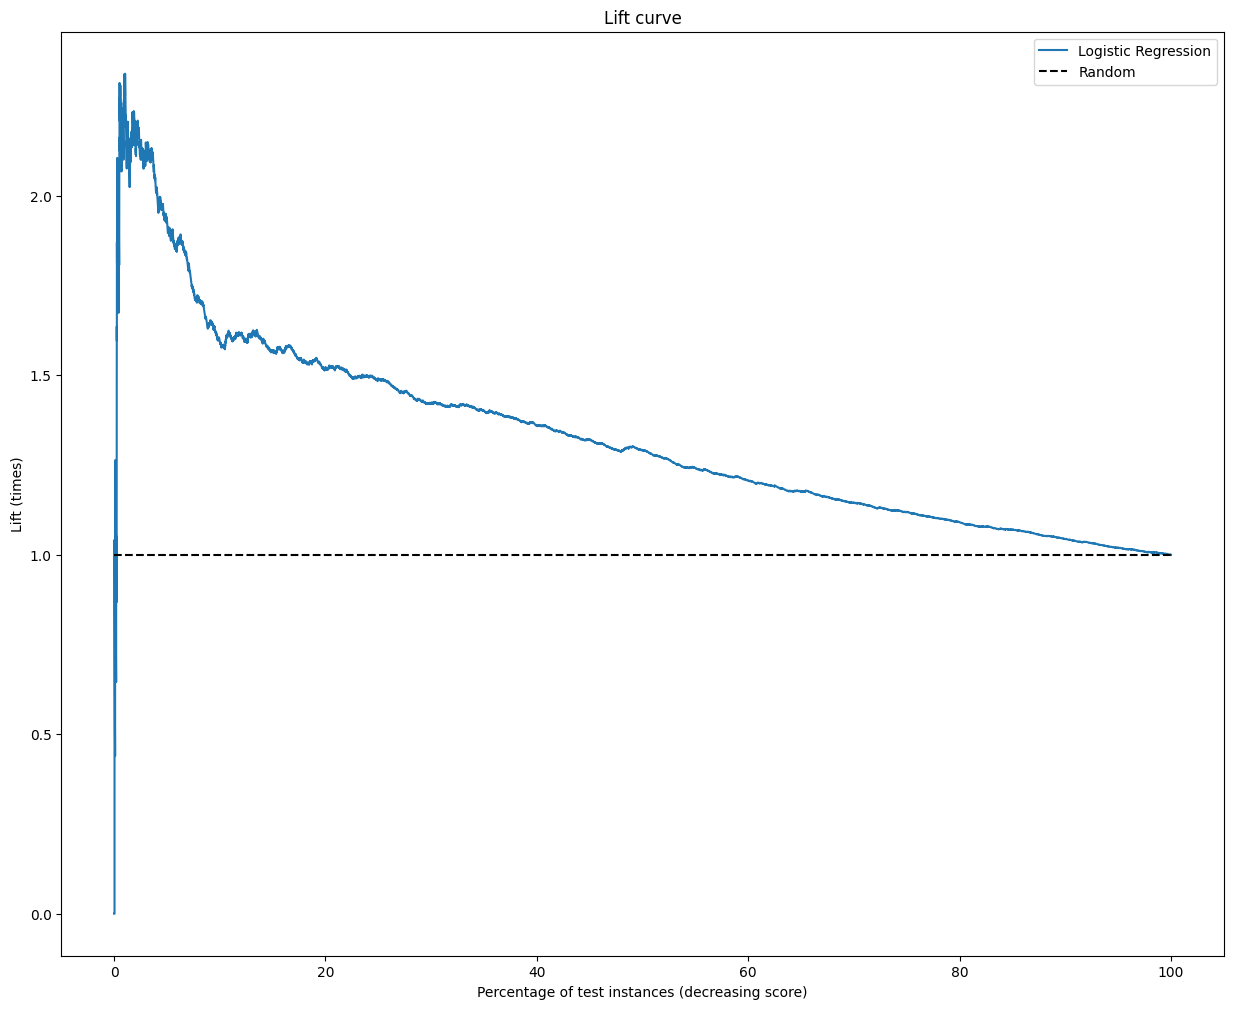

In [ ]:
def plot_lift_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative/x_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [1,1], 'k--', label="Random")
    plt.xlabel("Percentage of test instances (decreasing score)")
    plt.ylabel("Lift (times)")
    plt.title("Lift curve")
    plt.legend()

plot_lift_curve(models)

In [ ]:
## use plotly to identify the spot of maximal lift:
import plotly.graph_objects as go
for key in models:
  x_cumulative, y_cumulative = build_cumulative_curve(models[key])
  fig = go.Figure(data=go.Scatter(x=x_cumulative, y=y_cumulative/x_cumulative, mode='markers', name='namehere',
                  hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<extra></extra>'  # Custom hover text with rounding
  ))

# Customizing the layout for better readability and interactivity
fig.update_layout(title='Interactive Scatter Plot with Hover Information',
                  xaxis_title='Percentage of Test instances',
                 yaxis_title='Lift',
                  hovermode='closest')  # Show closest point to mouse hover

# Showing the plot
fig.show()


Now, let's compare the cumulative response curves and then the lift curves of two models (a logistic regression model and a tree).

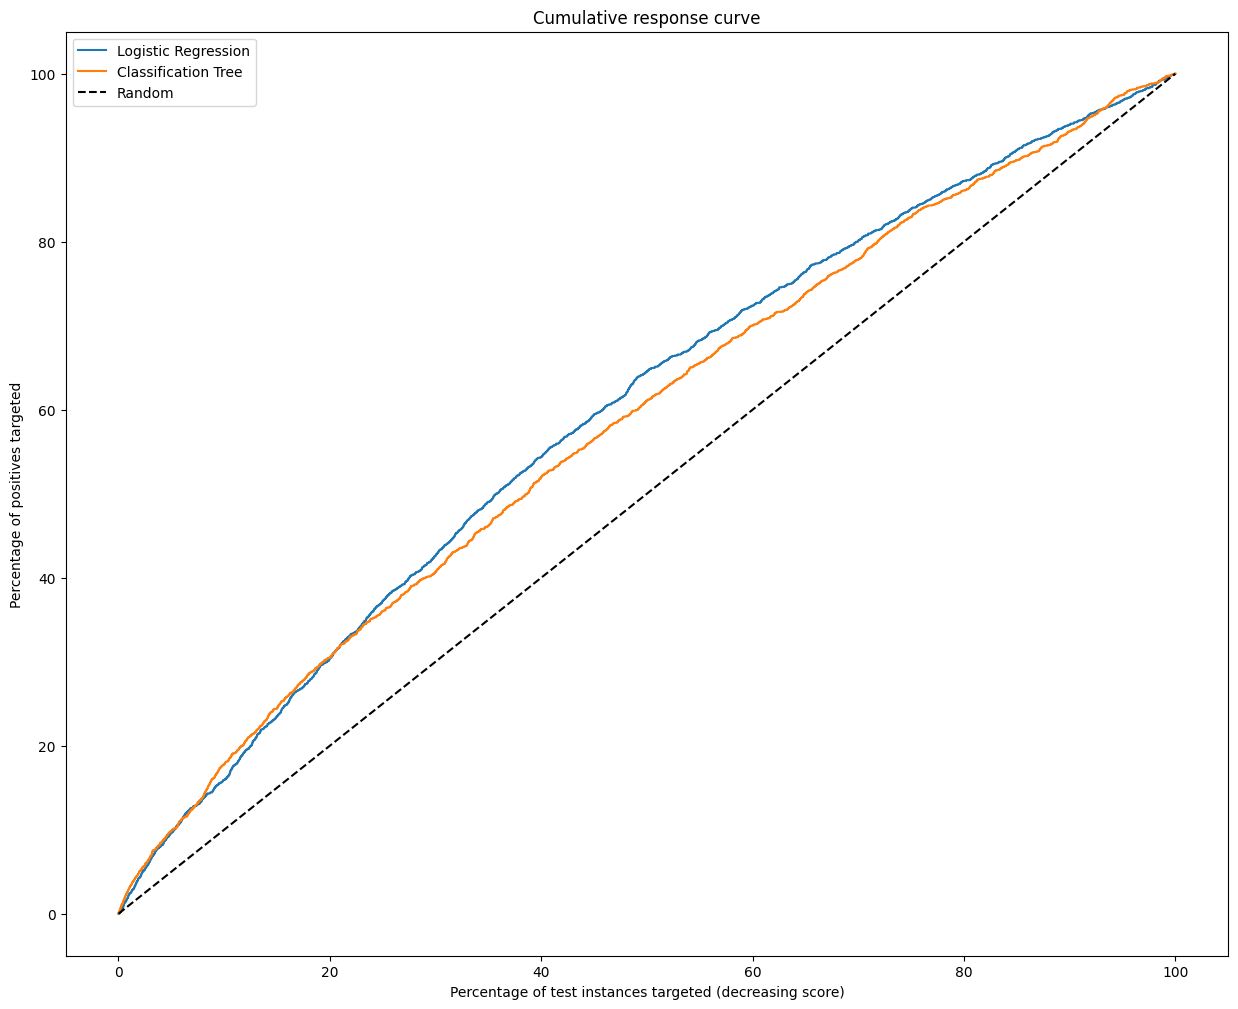

In [ ]:

X_train, X_test, Y_train, Y_test = X_mailing_train, X_mailing_test, Y_mailing_train, Y_mailing_test

models = {"Logistic Regression": LogisticRegression(C=1.0, solver="liblinear"),
          "Classification Tree": DecisionTreeClassifier(criterion="entropy", min_samples_leaf=300, random_state=42)
          }
plot_cumulative_curve(models)

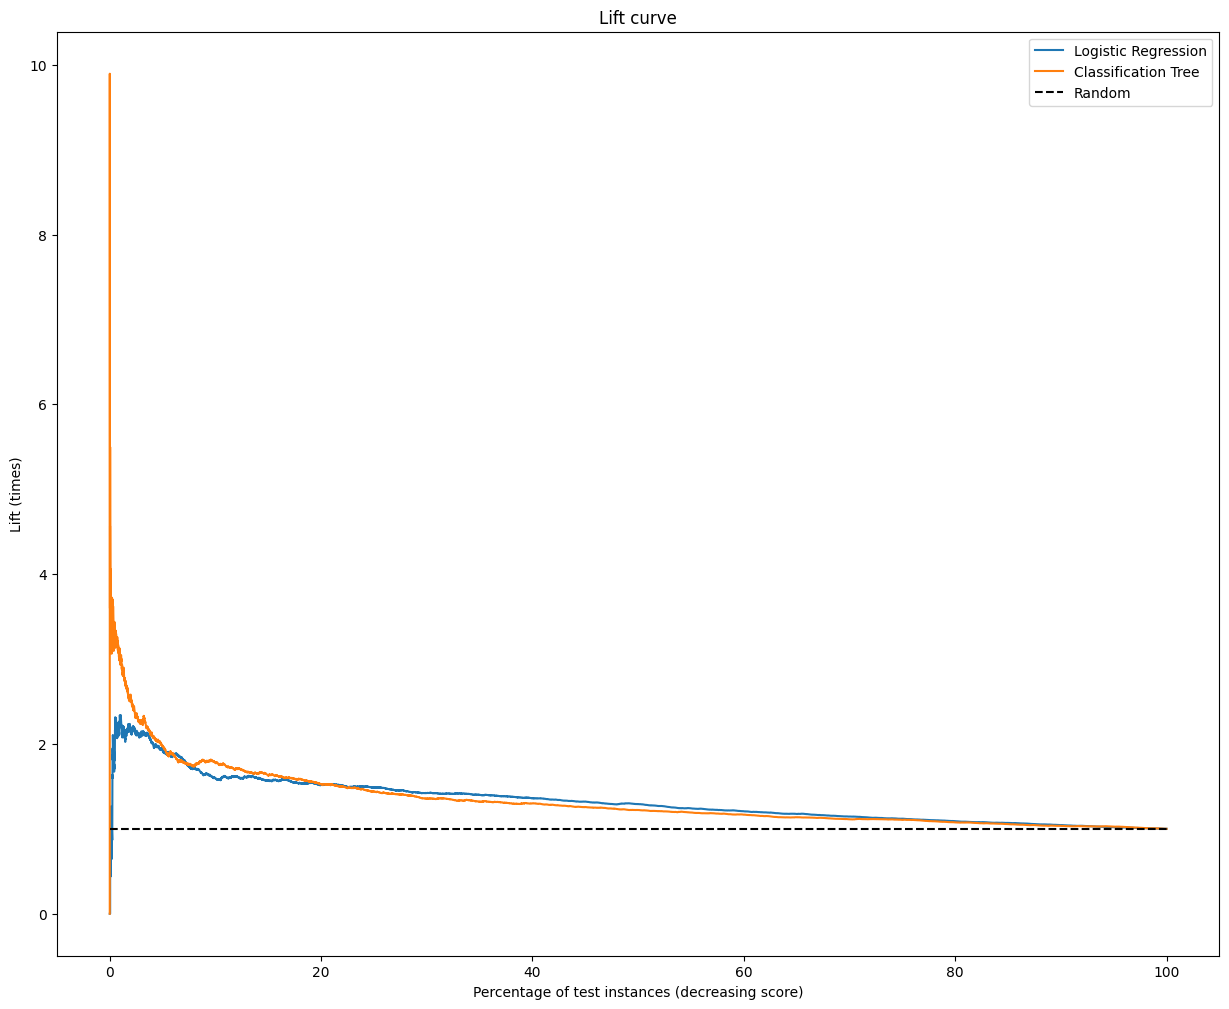

In [ ]:
plot_lift_curve(models)

What if we want to understand not just lift, but how much benefit we are going to receive from a certain investment in targeting?  We can plot a profit curve.


### Profit curves
Let's say that each offer costs \$1 to make and market, and each accepted offer earns \$18, for a profit of $17. The cost matrix would be:


In [ ]:
unit_cost = 1
unit_revenue = 18

cost_matrix = pd.DataFrame([[unit_revenue - unit_cost, - unit_cost], [0, 0]], columns=['p', 'n'], index=['Y', 'N'])
print ("Cost matrix")
print (cost_matrix)

Cost matrix
    p  n
Y  17 -1
N   0  0


Remember that we examined different targeting thresholds (aka "decision thresholds"):

In [ ]:
print ("Confusion matrix with threshold = 50% to predict labels")
print (confusion_matrix_50)
print ("\n")
print ("Confusion matrix with threshold = 5% to predict labels")
print (confusion_matrix_5)

Confusion matrix with threshold = 50% to predict labels
      p      n
Y     0      1
N  2423  45521


Confusion matrix with threshold = 5% to predict labels
      p      n
Y  1558  22281
N   865  23241


In [ ]:
targeted_matrix = pd.DataFrame([[1,1], [0, 0]], columns=['p', 'n'], index=['Y', 'N'])
print ("Targeted matrix")
print (targeted_matrix)


Targeted matrix
   p  n
Y  1  1
N  0  0


Based on those predictions, the expected profit of using 50% and 5% as your decision threshold would be.

In [ ]:
profit_w_50 = np.sum((confusion_matrix_50 * cost_matrix).values)
profit_w_5 = np.sum((confusion_matrix_5 * cost_matrix).values)

#count how many are targeted in each scenario
num_targeted_50 = np.sum((confusion_matrix_50 * targeted_matrix).values)
num_targeted_5 = np.sum((confusion_matrix_5 * targeted_matrix).values)

#print(num_targeted_50)
#print(num_targeted_5)

counting_matrix = pd.DataFrame([[1,1], [1, 1]], columns=['p', 'n'], index=['Y', 'N'])
#count how many total individuals in each scenario
num_50 = np.sum((confusion_matrix_50 * counting_matrix).values)
num_5 = np.sum((confusion_matrix_5 * counting_matrix).values)



In [ ]:
print ("Profit on test set with a cutoff of 50%% is $%.2f." % profit_w_50)
print ("Profit on test set with a cutoff of 5%% is $%.2f." % profit_w_5)

#now compute the expected profit per targeted individual
eppti_w_50 = profit_w_50 / num_targeted_50
eppti_w_5 = profit_w_5 / num_targeted_5

print ()
print ("Expected profit per targeted individual with a cutoff of 50%% is $%.2f." % eppti_w_50)
print ("Expected profit per targeted individual with a cutoff of 5%% is $%.2f." % eppti_w_5)

#now compute the expected profit per individual
eppi_w_50 = profit_w_50 / num_50
eppi_w_5 = profit_w_5 / num_5

print ()
print ("Expected profit per individual with a cutoff of 50%% is $%.2f." % eppi_w_50)
print ("Expected profit per individual with a cutoff of 5%% is $%.2f." % eppi_w_5)

Profit on test set with a cutoff of 50% is $-1.00.
Profit on test set with a cutoff of 5% is $4205.00.

Expected profit per targeted individual with a cutoff of 50% is $-1.00.
Expected profit per targeted individual with a cutoff of 5% is $0.18.

Expected profit per individual with a cutoff of 50% is $-0.00.
Expected profit per individual with a cutoff of 5% is $0.09.


And here is the profit curve.

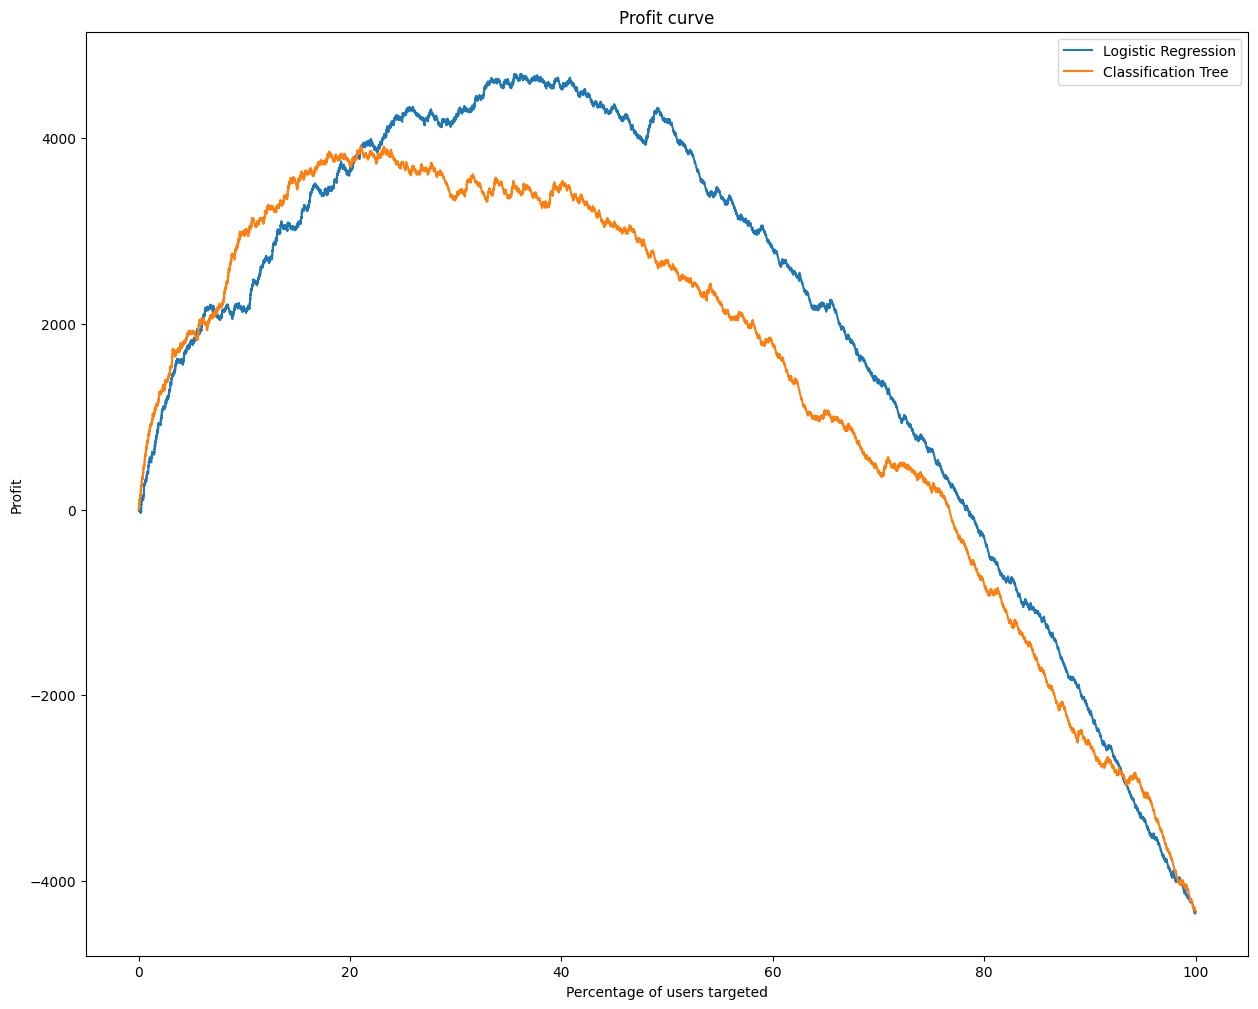

In [ ]:
unit_cost = -cost_matrix['n']['Y']
unit_revenue = cost_matrix['p']['Y'] + unit_cost

def plot_profit_curve(models):
    # Plot curve for each model
    total_obs = len(Y_test)
    total_pos = Y_test.sum()
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key], scale=1)
        profits = unit_revenue * y_cumulative * total_pos - unit_cost * x_cumulative * total_obs
        plt.plot(x_cumulative*100, profits, label=key)
    # Plot other details
    plt.xlabel("Percentage of users targeted")
    plt.ylabel("Profit")
    plt.title("Profit curve")
    plt.legend()

plot_profit_curve(models)

Which one do you think we should choose? Why?

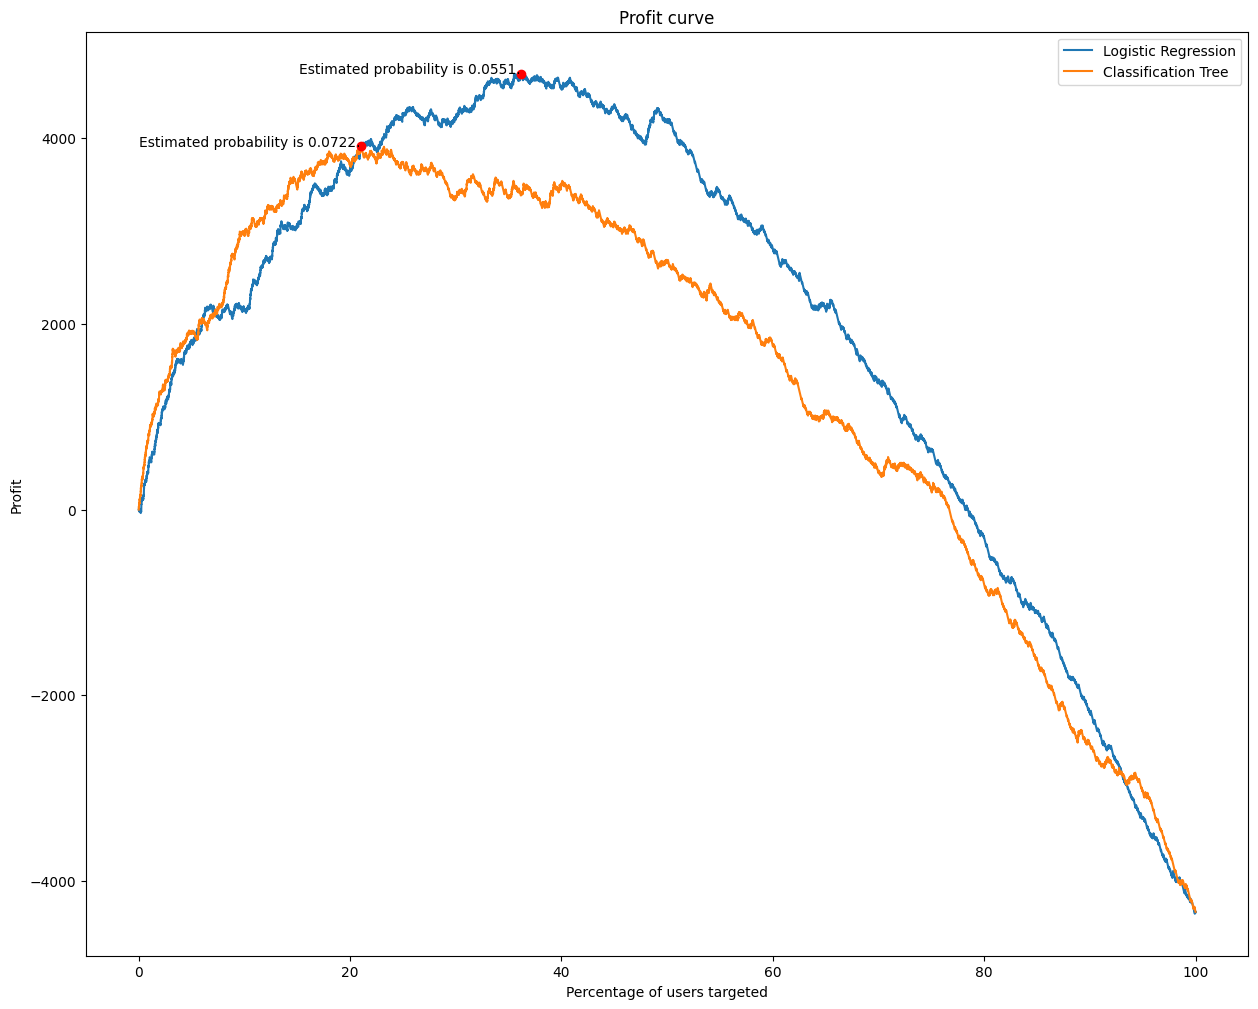

In [ ]:
unit_cost = -cost_matrix['n']['Y']
unit_revenue = cost_matrix['p']['Y'] + unit_cost

def plot_profit_curve(models):
    # Plot curve for each model
    total_obs = len(Y_test)
    total_pos = Y_test.sum()
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key], scale=1)

        profits = unit_revenue * y_cumulative * total_pos - unit_cost * x_cumulative * total_obs

        plt.plot(x_cumulative*100, profits, label=key)

        # Find the estimated probability
        Y_test_probability_1 = models[key].predict_proba(X_test)[:, 1]
        order = np.argsort(Y_test_probability_1)[::-1]
        Y_test_probability_1_sorted = Y_test_probability_1[order]
        # add the point to the plot
        plt.plot(x_cumulative[profits.argmax(axis=0)]*100,
                 profits[profits.argmax(axis=0)],
                 'ro')
        plt.text(x_cumulative[profits.argmax(axis=0)]*100,
                 profits[profits.argmax(axis=0)],"Estimated probability is %.4f." % Y_test_probability_1_sorted[profits.argmax(axis=0)],horizontalalignment='right')

    # Plot other details
    plt.xlabel("Percentage of users targeted")
    plt.ylabel("Profit")
    plt.title("Profit curve")
    plt.legend()

plot_profit_curve(models)